# No More Alzheimer's Disease

## General Data Processing

### Data Downloading

In [374]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from timeit import default_timer as timer
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

### Data Pre-Processing

Each necessary file is downloaded, unnecessary fields are removed and labels are assigned.

In [375]:

'''This function reads and does some pre-processing for the data files provided.'''

ugot = pd.read_csv("Data/Plasma/UGOTPTAU181_06_18_20_27Nov2023.csv")
# Read the labels that will be used for both of the files
labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]


#-------------------------UGOT------------------------------------------------------------------------
# Now merge these two files and remove any rows that have null values
ugot = pd.merge(ugot, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna(subset=['RID', 'PLASMAPTAU181', 'DX'])
# Update Stamp is not relevant for this test
ugot.drop(['update_stamp', 'VISCODE', 'VISCODE2', 'COMMENT', 'VID', 'EXAMDATE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
ugot = ugot.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
ugot.to_csv("Data/ProcessedData/UGOT.csv", index=False)

# -------------------------UPENN----------------------------------------------------------------------
upenn = pd.read_csv("Data/Plasma/UPENNPLASMA_27Nov2023.csv")
upenn = pd.merge(upenn, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
upenn.drop(['update_stamp', 'VISCODE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
upenn = upenn.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
upenn.to_csv("Data/ProcessedData/UPENN.csv", index=False)

# --------------------------ADNI_MERGE-----------------------------------------------------------------
adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")
adni_merge = adni_merge.loc[:, ~adni_merge.columns.str.endswith('_bl')]
adni_merge = adni_merge.loc[:, ['RID', 'DX', 'MMSE', 'AGE', 'PTAU', 'TAU', 'ABETA']]
regex_pattern = r'[<>](\d+)'

# This applies to all columns
adni_merge = adni_merge.apply(lambda col: col.astype(str).str.replace(regex_pattern, r'\1', regex=True))
adni_merge = adni_merge.replace('nan', np.nan).dropna()

#change to required format
adni_merge = adni_merge.replace("CN", "SCD").replace("Dementia", "AD")
adni_merge.to_csv("Data/ProcessedData/ADNIMerge.csv")

# --------------------------PLASMA_ABETA_PROJECT--------------------------------------------------------
p_ab = pd.read_csv('Data/Plasma/PLASMA_ABETA_PROJECT_ADX_VUMC_27Nov2023.csv')
# Drop the VISCODE column and replace it with VISCODE2 (REFERENCE :: https://groups.google.com/g/adni-data/c/Dx_Rgge_XB0)
p_ab.drop('VISCODE', inplace=True, axis=1)
p_ab.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
p_ab = pd.merge(p_ab, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
p_ab = p_ab.loc[:, ['RID', 'DX', 'SEQ', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP']]
p_ab = p_ab.replace("CN", "SCD").replace('Dementia', 'AD')


p_ab.to_csv('Data/ProcessedData/Plasma_AB.csv')





/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_64631/1773404187.py:5: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]
/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_64631/1773404187.py:26: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")


In [376]:
# Read each of the files and select the useful fields

blen = pd.read_csv('Data/Plasma/ADNI_BLENNOWPLASMANFL_10_03_18_27Nov2023.csv')[['RID', 'VISCODE2', 'PLASMA_NFL']]
fnih = pd.read_csv('Data/Plasma/FNIH_PLASMA_PTAU181_PROJECT_27Nov2023.csv')[['RID', 'VISCODE2', 'PTAU_181']]
#??????
# fuji = pd.read_csv('Data/Plasma/FUJIREBIOABETAPLASMA_06Dec2023.csv')[['RID', 'VISCODE2', 'PTAU_181']]
#??????
plasmaab = pd.read_csv('Data/Plasma/PLASMA_ABETA_PROJECT_ADX_VUMC_27Nov2023.csv')[['RID', 'VISCODE2', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP']]
ugot = pd.read_csv('Data/Plasma/UGOTPTAU181_06_18_20_27Nov2023.csv')[['RID', 'VISCODE2', 'PLASMAPTAU181']] # RENAME PTAU
dian = pd.read_csv('Data/Plasma/UPENNPLASMA_27Nov2023.csv')[['RID', 'VISCODE', 'AB40', 'AB42']]

# Rename all of the VISCODE2 => VISCODE for merging
blen.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
fnih.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
plasmaab.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
ugot.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)

# Rename PLASMAPTAU181 => PTAU_181 for merging
ugot.rename(columns={'PLASMAPTAU181' : 'PTAU_181'}, inplace=True)

# Attempt to merge
df = pd.merge(blen, fnih, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, plasmaab, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, ugot, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, dian, on=['RID', 'VISCODE'], how='outer')

# Now assign a label to each item
labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]
df = pd.merge(df, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').replace('CN', 'SCD').replace('Dementia', 'AD')

# Remove any items that couldn't be classified
df = df.dropna(subset=['DX'])
df.drop("VISCODE", inplace=True, axis=1)

df.to_csv('Data/ProcessedData/ALL_PLASMA_MERGED.csv')

# Now select the plasma biomarkers required and remove any ones with null fields

df = df[['PTAU_181_x', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP', 'DX']].dropna()
df.to_csv('Data/ProcessedData/PLASMA_MERGED.csv', index=False)

/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_64631/2928537037.py:28: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]


### General Functions

In [377]:
def getXy(df):
    '''
    Seperate the label from the feature data.
    
    Args : 
        df (DataFrame) : The data to be seperated
    Returns :
        X (DataFrame) : The feature data.
        y (list) : The labels associated.'''
    
    # Independant
    X = df.drop("DX", axis=1).values
    # Dependant
    y = df["DX"].values

    return X, y

In [378]:
def get_different_classes(df):
    '''
        This function returns the three different classes, seperated into different dataframes.
        
        Args :
            df (DataFrame) : The dataframe containing all the label and feature data.
        Returns :
            SCD, MCI, AD : Each of the different labels (with the feature data) seperated into dataframes'''
    
    SCD = df.loc[df["DX"] == "SCD"]
    MCI = df.loc[df["DX"] == "MCI"]
    AD = df.loc[df["DX"] == "AD"]

    return SCD, MCI, AD

In [379]:
def split_test_data(SCD, MCI, AD, TestingFactor = 0.25):
    '''
        Now we seperate the training and testing data. Currently using a 25% training test split.

        Args : 
            SCD, MCI, AD (DataFrame) : Data to be split, already split into classes.
            TestingFactor (int) [OPTIONAL] : Amount of data put in testing.
        Returns :
            SCD, MCI, AD, TestData (DataFrame) : Each of the sections of data.
    
    '''

    SCD, TempSCD = train_test_split(SCD, test_size=TestingFactor)
    MCI, TempMCI = train_test_split(MCI, test_size=TestingFactor)
    AD, TempAD = train_test_split(AD, test_size=TestingFactor)

    # concatenate the lists
    TempData = [TempSCD, TempMCI, TempAD]
    TestData = pd.concat(TempData)

    # return required info
    return SCD, MCI, AD, TestData

In [380]:
def display_results_table(bdt_data, ovo_data):
    '''
        This outputs the table in a visually appealing way.
        
        Arguments :
            bdt_data : The data formatted in the order Names, Time, Accuracy.
            ovo_data : The data formatted in the order Names, Time, Accuracy.
    '''

    # SOURCE : https://medium.com/@HeCanThink/tabulate-your-go-to-solution-for-stylish-tables-in-python-35ede5145e28#:~:text=Tabulate%3A%20Your%20Go%2DTo%20Solution%20for%20Stylish%20Tables%20in%20Python%20%F0%9F%91%89,-Manoj%20Das&text=With%20the%20Tabulate%20library%2C%20you,customized%20to%20suit%20your%20preferences.

    bdt_df = pd.DataFrame(bdt_data)
    ovo_df = pd.DataFrame(ovo_data)

    # Display DataFrames
    print("Binary Decision Tree SVM")
    print(tabulate(bdt_df, headers="keys", tablefmt="pretty", showindex=False))

    print("\nOne v One SVM")
    print(tabulate(ovo_df, headers="keys", tablefmt="pretty", showindex=False))
    


In [381]:
def display_results_graph(approach, bdt, ovo, sizes):
    '''
        This outputs the graph representation of the data provided. Currently it compares the results and the data set sizes

        Arguments :
            approach (str) : says whether this is for an SVM or a RF.
            bdt : The data formatted in the order Names, Time, Accuracy.
            ovo : The data formatted in the order Names, Time, Accuracy.
            sums : The sizes of all the different data sets.
    '''

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    bdt = pd.DataFrame(bdt)
    ovo = pd.DataFrame(ovo)

    fig.suptitle(approach, y=1.03)

    # Plot time taken as x, accuracy as y
    axes[0].set_xlabel("Time Taken to Train and Test (s)")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].scatter(bdt.loc[bdt['Dataset'] == 'UPENN', 'Time Taken'].values[0], bdt.loc[bdt['Dataset'] == 'UPENN', 'Accuracy'].values[0], label='UPENN', color='blue')
    axes[0].scatter(bdt.loc[bdt['Dataset'] == 'UGOT', 'Time Taken'].values[0], bdt.loc[bdt['Dataset'] == 'UGOT', 'Accuracy'].values[0], label='UGOT', color='green')
    axes[0].scatter(bdt.loc[bdt['Dataset'] == 'ADNI', 'Time Taken'].values[0], bdt.loc[bdt['Dataset'] == 'ADNI', 'Accuracy'].values[0], label='ADNI', color='red')
    axes[0].scatter(bdt.loc[bdt['Dataset'] == 'ABETA', 'Time Taken'].values[0], bdt.loc[bdt['Dataset'] == 'ABETA', 'Accuracy'].values[0], label='ABETA', color='purple')
    axes[0].scatter(bdt.loc[bdt['Dataset'] == 'PLASMA', 'Time Taken'].values[0], bdt.loc[bdt['Dataset'] == 'PLASMA', 'Accuracy'].values[0], label='PLASMA', color='grey')

    axes[0].scatter(ovo.loc[ovo['Dataset'] == 'UPENN', 'Time Taken'].values[0], ovo.loc[ovo['Dataset'] == 'UPENN', 'Accuracy'].values[0], color='blue', marker='x')
    axes[0].scatter(ovo.loc[ovo['Dataset'] == 'UGOT', 'Time Taken'].values[0], ovo.loc[ovo['Dataset'] == 'UGOT', 'Accuracy'].values[0], color='green', marker='x')
    axes[0].scatter(ovo.loc[ovo['Dataset'] == 'ADNI', 'Time Taken'].values[0], ovo.loc[ovo['Dataset'] == 'ADNI', 'Accuracy'].values[0], color='red', marker='x')
    axes[0].scatter(ovo.loc[ovo['Dataset'] == 'ABETA', 'Time Taken'].values[0], ovo.loc[ovo['Dataset'] == 'ABETA', 'Accuracy'].values[0], color='purple', marker='x')
    axes[0].scatter(ovo.loc[ovo['Dataset'] == 'PLASMA', 'Time Taken'].values[0], ovo.loc[ovo['Dataset'] == 'PLASMA', 'Accuracy'].values[0], color='grey', marker='x')

    axes[0].set_title("Comparison of OvO (x) and BDT (o) approaches")
    axes[0].legend()

    # Now plot the data set sizes
    categoroies = ['UPENN', 'UGOT', 'ADNI', 'ABETA', 'Plasma File']

    axes[1].bar(categoroies, sizes)
    axes[1].set_xlabel('Categories')
    axes[1].set_ylabel('Test Data Set Sizes')
    axes[1].set_title('Test Data Set Sizes Comparison')

    plt.show()

### SVM Approach

In [382]:
def construct_svm(df1, df2):
    '''
        Constructs an SVM with the datasets provided.

        Args :
            Datasets (DataFrame) : Two DataFrames that the SVM must be made upon.
        Returns :
            Classifier (SVC) : This is the margin that the data must be acted upon.
            Scaler (StandardScaler) : Used in testing.
    '''

    # First the two dataframes should be combined
    df = [df1, df2]
    df = pd.concat(df)
    # Get data in the format required
    X, y = getXy(df)
    # Train the classifier
    sc = StandardScaler()
    X = sc.fit_transform(X)
    # Fit to the classifier
    classifier = SVC(kernel='rbf', random_state=0)
    classifier.fit(X, y)

    return classifier, sc

In [383]:
def test_svm(classifier, scaler, X):
    '''
        Test the dataset with each individual SVM

        Args :
            classifier (SVM) : The Support Vector Machine used for this test
            scaler (StandardScaler) : This allows the test data to be scaled to the same proportions as the test data
            X (DataFrame) : The feature data WITHOUT labels
        Returns :
            y_pred (list) : the predicted y-value for each item
    '''
    # now perform the classification
    X = scaler.fit_transform(X)
    y_pred = classifier.predict(X)
    # return the result of this transaction
    return y_pred

### Binary Decision Tree SVM Classifier

In [384]:
def bdt_svm(file_path):
    '''
        Perform the Binary Decision Tree SVM classification method.
        
        Args :
            file_path (String) : Path to the data
        Returns :
            time (float) : Time taken to perform the test.
            accuracy (float) : The accuracy of the model.
            confusion_matrix : Confusion matrix for the accuracy.'''
    
    df = pd.read_csv(file_path)
    
    start = timer()
    # Now seperate the labels
    SCD, MCI, AD = get_different_classes(df)
    # get the test data required, leave training data
    SCD, MCI, AD, TestData = split_test_data(SCD, MCI, AD)
    

    # seperate the labels and the data features
    X_test, y_test = getXy(TestData)

    # Concatenate MCI
    MCIoAD = [MCI, AD]
    MCIoAD = pd.concat(MCIoAD)
    # Map to the same class
    MCIoAD = MCIoAD.replace("MCI", "MCIoAD").replace("AD", "MCIoAD")

    # Test to perform the first step of the DT
    SCDMCIAD, scalersma = construct_svm(SCD, MCIoAD)
    # SVM for the second level of the BDT
    MCIAD, scalarma = construct_svm(MCI, AD)

    # Perform the test for the first level of BDT
    SCDoMCIAD = test_svm(SCDMCIAD, scalersma, X_test)

    # Now run entire set through the MCI, AD classifier. 
    # However, only the non-SCD items in the previous test will be used
    MCIoAD = test_svm(MCIAD, scalarma, X_test)

    # Now colalate the results together taking the two classifiers into account
    results = []
    
    for i in range(len(SCDoMCIAD)):
        if SCDoMCIAD[i] == 'SCD':
            results.append('SCD')
        else:
            # Adds the result of the second level
            results.append(MCIoAD[i])

    # Print out the time taken and results
    end = timer()

    # construct a confusion matrix
    cm = confusion_matrix(y_test, results)

    return end-start, accuracy_score(y_test, results), cm

### OnevOne SVM Classifier

In [385]:
def ovo_svm(file_path):
    '''
        Perform the One v One SVM classification method.
        
        Args :
            file_path (String) : Path to the data
        Returns :
            time (float) : Time taken to perform the test.
            accuracy (float) : The accuracy of the model.
            confusion_matrix : Confusion matrix for the accuracy.'''
    

    df = pd.read_csv(file_path)

    # Keep track of the time taken after file read
    start = timer()
    # Now seperate the labels
    SCD, MCI, AD = get_different_classes(df)
    # get the test data required, leave training data
    SCD, MCI, AD, TestData = split_test_data(SCD, MCI, AD)

    # seperate the labels and the data features
    X_test, y_test = getXy(TestData)

    # Construct the three different SVMs
    SCDMCI, scalersm = construct_svm(SCD, MCI)
    MCIAD, scalerma = construct_svm(MCI, AD)
    SCDAD, scalersa = construct_svm(SCD, AD)

    # Perform the individual tests
    pred1 = test_svm(SCDMCI, scalersm, X_test)
    pred2 = test_svm(MCIAD, scalerma, X_test)
    pred3 = test_svm(SCDAD, scalersa, X_test)

    # This now gets the most common item to appear in the lists

    common = ["-1" for i in range(len(pred1))]
    notClassified = 0

    # classify values that have atleast a 2 in a majority voting scheme
    for i in range(len(pred1)):
        if (pred1[i] == pred2[i]) or (pred1[i] == pred3[i]):
            common[i] = pred1[i]
        elif (pred2[i] == pred3[i]):
            common[i] = pred2[i]

    cm = confusion_matrix(y_test, common)

    end = timer()

    return end-start, accuracy_score(y_test, common), cm 

    

### Results

In [386]:
# Naming Convention : TreeType_Study_Measure

# Tree Type
    # bdt :: Binary Decision Tree
    # ovo :: One v One
# Study
    # up :: UPENN
    # ug :: UGOT
    # am :: ADNI_MERGE
    # pab :: Plasma_AB
# Measure
    # time :: Time taken to complete
    # acc :: Classification Accuracy
    # cm :: Confusion Matrix

bdt_up_time, bdt_up_acc, bdt_up_cm = bdt_svm('Data/ProcessedData/UPENN.csv')
bdt_ug_time, bdt_ug_acc, bdt_ug_cm = bdt_svm('Data/ProcessedData/UGOT.csv')
bdt_am_time, bdt_am_acc, bdt_am_cm = bdt_svm('Data/ProcessedData/ADNIMerge.csv')
bdt_pab_time, bdt_pab_acc, bdt_pab_cm = bdt_svm('Data/ProcessedData/Plasma_AB.csv')
bdt_plasma_time, bdt_plasma_acc, bdt_plasma_cm = bdt_svm('Data/ProcessedData/PLASMA_MERGED.csv')

ovo_up_time, ovo_up_acc, ovo_up_cm = ovo_svm('Data/ProcessedData/UPENN.csv')
ovo_ug_time, ovo_ug_acc, ovo_ug_cm = ovo_svm('Data/ProcessedData/UGOT.csv')
ovo_am_time, ovo_am_acc, ovo_am_cm = ovo_svm('Data/ProcessedData/ADNIMerge.csv')
ovo_pab_time, ovo_pab_acc, ovo_pab_cm = ovo_svm('Data/ProcessedData/Plasma_AB.csv')
ovo_plasma_time, ovo_plasma_acc, ovo_plasma_cm = ovo_svm('Data/ProcessedData/PLASMA_MERGED.csv')

#Display the results

bdt_data = {
    "Dataset": ["UGOT", "UPENN", "ADNI", "ABETA", "PLASMA"],
    "Time Taken": [bdt_ug_time, bdt_up_time, bdt_am_time, bdt_pab_time, bdt_plasma_time],
    "Accuracy": [bdt_ug_acc, bdt_up_acc, bdt_am_acc, bdt_pab_acc, bdt_plasma_acc]
}

# Data for One v One SVM
ovo_data = {
    "Dataset": ["UGOT", "UPENN", "ADNI", "ABETA", "PLASMA"],
    "Time Taken": [ovo_ug_time, ovo_up_time, ovo_am_time, ovo_pab_time, ovo_plasma_time],
    "Accuracy": [ovo_ug_acc, ovo_up_acc, ovo_am_acc, ovo_pab_acc, ovo_plasma_acc]
}

display_results_table(bdt_data, ovo_data)


Binary Decision Tree SVM
+---------+-----------------------+--------------------+
| Dataset |      Time Taken       |      Accuracy      |
+---------+-----------------------+--------------------+
|  UGOT   |  0.17463245900034963  | 0.532620320855615  |
|  UPENN  |  0.11522737499944924  | 0.3913764510779436 |
|  ADNI   |  0.06286495799940894  | 0.7077702702702703 |
|  ABETA  | 0.0042250420001437305 |        0.5         |
| PLASMA  | 0.0057667499995659455 | 0.6160714285714286 |
+---------+-----------------------+--------------------+

One v One SVM
+---------+----------------------+--------------------+
| Dataset |      Time Taken      |      Accuracy      |
+---------+----------------------+--------------------+
|  UGOT   | 0.19471129199973802  | 0.5668449197860963 |
|  UPENN  | 0.11094299999967916  | 0.4427860696517413 |
|  ADNI   |  0.0630392920002123  | 0.6655405405405406 |
|  ABETA  | 0.004558459000691073 | 0.6071428571428571 |
| PLASMA  | 0.00727424999968207  | 0.6428571428571429 |

### Results Visualisation

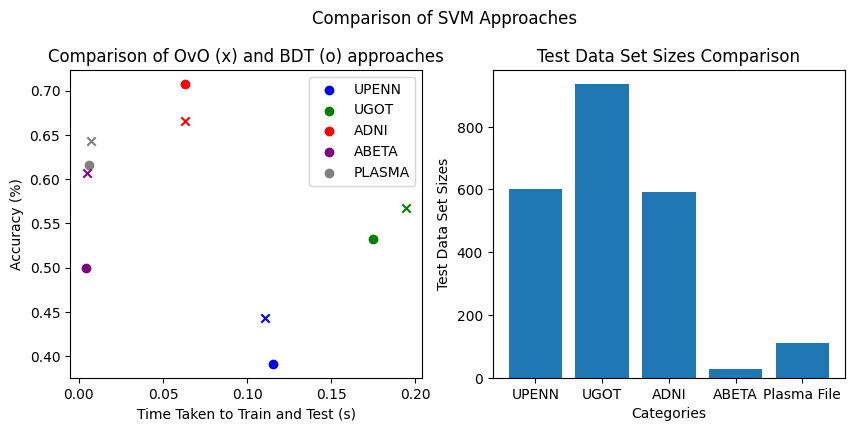

In [387]:
# Now plot the data set sizes
sizes = [bdt_up_cm.sum(), bdt_ug_cm.sum(), bdt_am_cm.sum(), bdt_pab_cm.sum(), bdt_plasma_cm.sum()]

display_results_graph("Comparison of SVM Approaches", bdt_data, ovo_data, sizes)

# Random Forest Approach

In [388]:
from sklearn.ensemble import RandomForestClassifier

In [389]:
def construct_rf(df1, df2):
    '''
        Constructs a RF with the datasets provided.

        Args :
            Datasets (DataFrame) : Two DataFrames that the RF must be made upon.
        Returns :
            Classifier (StandardScaler) : Used in testing.
    '''

    # Source :: https://www.datacamp.com/tutorial/random-forests-classifier-python

    # First the two dataframes should be combined
    df = [df1, df2]
    df = pd.concat(df)
    # Get data in the format required
    X, y = getXy(df)
    # Fit to the classifier
    classifier = RandomForestClassifier()
    classifier.fit(X, y)

    return classifier

In [390]:
def test_rf(classifier, X):
    '''
        Test the dataset with each individual SVM

        Args :
            classifier (SVM) : The Support Vector Machine used for this test
            scaler (StandardScaler) : This allows the test data to be scaled to the same proportions as the test data
            X (DataFrame) : The feature data WITHOUT labels
        Returns :
            y_pred (list) : the predicted y-value for each item
    '''
    # now perform the classification
    y_pred = classifier.predict(X)
    # return the result of this transaction
    return y_pred

### Binary Decision Tree Random Forest

In [391]:
def ovo_rf(file_path):
    '''
        Perform the One v One RF classification method.
        
        Args :
            file_path (String) : Path to the data
        Returns :
            time (float) : Time taken to perform the test.
            accuracy (float) : The accuracy of the model.
            confusion_matrix : Confusion matrix for the accuracy.'''
    

    df = pd.read_csv(file_path)

    # Keep track of the time taken after file read
    start = timer()
    # Now seperate the labels
    SCD, MCI, AD = get_different_classes(df)
    # get the test data required, leave training data
    SCD, MCI, AD, TestData = split_test_data(SCD, MCI, AD)

    # seperate the labels and the data features
    X_test, y_test = getXy(TestData)

    # Construct the three different RFs
    SCDMCI = construct_rf(SCD, MCI)
    MCIAD = construct_rf(MCI, AD)
    SCDAD = construct_rf(SCD, AD)

    # Perform the individual tests
    pred1 = test_rf(SCDMCI, X_test)
    pred2 = test_rf(MCIAD, X_test)
    pred3 = test_rf(SCDAD, X_test)

    # This now gets the most common item to appear in the lists

    common = ["-1" for i in range(len(pred1))]
    notClassified = 0

    # classify values that have atleast a 2 in a majority voting scheme
    for i in range(len(pred1)):
        if (pred1[i] == pred2[i]) or (pred1[i] == pred3[i]):
            common[i] = pred1[i]
        elif (pred2[i] == pred3[i]):
            common[i] = pred2[i]

    cm = confusion_matrix(y_test, common)

    end = timer()

    return end-start, accuracy_score(y_test, common), cm 

    

In [392]:
def bdt_rf(file_path):
    '''
        Perform the Binary Decision Tree RF classification method.
        
        Args :
            file_path (String) : Path to the data
        Returns :
            time (float) : Time taken to perform the test.
            accuracy (float) : The accuracy of the model.
            confusion_matrix : Confusion matrix for the accuracy.'''
    
    df = pd.read_csv(file_path)
    
    start = timer()
    # Now seperate the labels
    SCD, MCI, AD = get_different_classes(df)
    # get the test data required, leave training data
    SCD, MCI, AD, TestData = split_test_data(SCD, MCI, AD)
    

    # seperate the labels and the data features
    X_test, y_test = getXy(TestData)

    # Concatenate MCI
    MCIoAD = [MCI, AD]
    MCIoAD = pd.concat(MCIoAD)
    # Map to the same class
    MCIoAD = MCIoAD.replace("MCI", "MCIoAD").replace("AD", "MCIoAD")

    # Test to perform the first step of the DT
    SCDMCIAD = construct_rf(SCD, MCIoAD)
    # SVM for the second level of the BDT
    MCIAD = construct_rf(MCI, AD)

    # Perform the test for the first level of BDT
    SCDoMCIAD = test_rf(SCDMCIAD, X_test)

    # Now run entire set through the MCI, AD classifier. 
    # However, only the non-SCD items in the previous test will be used
    MCIoAD = test_rf(MCIAD, X_test)

    # Now colalate the results together taking the two classifiers into account
    results = []
    
    for i in range(len(SCDoMCIAD)):
        if SCDoMCIAD[i] == 'SCD':
            results.append('SCD')
        else:
            # Adds the result of the second level
            results.append(MCIoAD[i])

    # Print out the time taken and results
    end = timer()

    # construct a confusion matrix
    cm = confusion_matrix(y_test, results)

    return end-start, accuracy_score(y_test, results), cm


### Results

This is done for One v One RF and Binary Decision Tree RFs.

In [395]:
from tabulate import tabulate
# Perform the tests using the naming convention described in the SVM section.

bdt_up_time, bdt_up_acc, bdt_up_cm = bdt_rf('Data/ProcessedData/UPENN.csv')
bdt_ug_time, bdt_ug_acc, bdt_ug_cm = bdt_rf('Data/ProcessedData/UGOT.csv')
bdt_am_time, bdt_am_acc, bdt_am_cm = bdt_rf('Data/ProcessedData/ADNIMerge.csv')
bdt_pab_time, bdt_pab_acc, bdt_pab_cm = bdt_rf('Data/ProcessedData/Plasma_AB.csv')
bdt_plasma_time, bdt_plasma_acc, bdt_plasma_cm = bdt_rf('Data/ProcessedData/PLASMA_MERGED.csv')

ovo_up_time, ovo_up_acc, ovo_up_cm = ovo_rf('Data/ProcessedData/UPENN.csv')
ovo_ug_time, ovo_ug_acc, ovo_ug_cm = ovo_rf('Data/ProcessedData/UGOT.csv')
ovo_am_time, ovo_am_acc, ovo_am_cm = ovo_rf('Data/ProcessedData/ADNIMerge.csv')
ovo_pab_time, ovo_pab_acc, ovo_pab_cm = ovo_rf('Data/ProcessedData/Plasma_AB.csv')
ovo_plasma_time, ovo_plasma_acc, ovo_plasma_cm = ovo_rf('Data/ProcessedData/PLASMA_MERGED.csv')

# Print out the results

# SOURCE (For Table Display) : https://medium.com/@HeCanThink/tabulate-your-go-to-solution-for-stylish-tables-in-python-35ede5145e28#:~:text=Tabulate%3A%20Your%20Go%2DTo%20Solution%20for%20Stylish%20Tables%20in%20Python%20%F0%9F%91%89,-Manoj%20Das&text=With%20the%20Tabulate%20library%2C%20you,customized%20to%20suit%20your%20preferences.

bdt_data = {
    "Dataset": ["UGOT", "UPENN", "ADNI", "ABETA", "PLASMA"],
    "Time Taken": [bdt_ug_time, bdt_up_time, bdt_am_time, bdt_pab_time, bdt_plasma_time],
    "Accuracy": [bdt_ug_acc, bdt_up_acc, bdt_am_acc, bdt_pab_acc, bdt_plasma_acc]
}

# Data for One v One SVM
ovo_data = {
    "Dataset": ["UGOT", "UPENN", "ADNI", "ABETA", "PLASMA"],
    "Time Taken": [ovo_ug_time, ovo_up_time, ovo_am_time, ovo_pab_time, ovo_plasma_time],
    "Accuracy": [ovo_ug_acc, ovo_up_acc, ovo_am_acc, ovo_pab_acc, ovo_plasma_acc]
}

display_results_table(bdt_data, ovo_data)


# TODO :: Tune hyper-parameters of RF
# TODO :: Make More Results

# TODO :: Fix my dam data (only have 400 items in total)
# TODO :: Refactor the code to make more readable (move plasma merged logic and move files)

Binary Decision Tree SVM
+---------+---------------------+---------------------+
| Dataset |     Time Taken      |      Accuracy       |
+---------+---------------------+---------------------+
|  UGOT   | 0.37181425000017043 | 0.6128342245989304  |
|  UPENN  | 0.2809170829996219  | 0.46102819237147596 |
|  ADNI   | 0.29840024999975867 | 0.7888513513513513  |
|  ABETA  | 0.09383075000005192 | 0.4642857142857143  |
| PLASMA  | 0.11165650000020833 | 0.9642857142857143  |
+---------+---------------------+---------------------+

One v One SVM
+---------+---------------------+---------------------+
| Dataset |     Time Taken      |      Accuracy       |
+---------+---------------------+---------------------+
|  UGOT   | 0.4442304590002095  | 0.6299465240641712  |
|  UPENN  | 0.3522054160002881  | 0.46102819237147596 |
|  ADNI   | 0.35526916700018774 | 0.7820945945945946  |
|  ABETA  | 0.13761395900019124 | 0.6785714285714286  |
| PLASMA  | 0.15799616699951002 |         1.0         |
+-------

### Results Visualisation

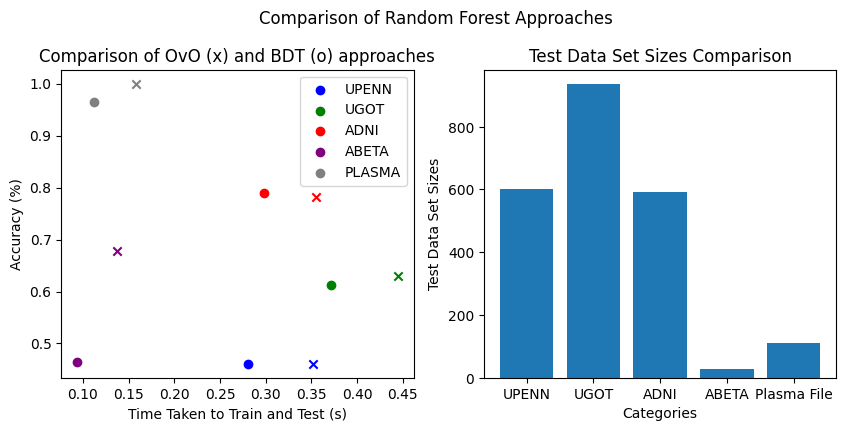

In [396]:
sizes = [bdt_up_cm.sum(), bdt_ug_cm.sum(), bdt_am_cm.sum(), bdt_pab_cm.sum(), bdt_plasma_cm.sum()]
categoroies = ['UPENN', 'UGOT', 'ADNI', 'ABETA', 'Plasma File']

# Display the results
display_results_graph("Comparison of Random Forest Approaches", bdt_data, ovo_data, sizes)

In [ ]:
# TODO :: Make a conclusion on this part of the experiment
# TODO :: Tune hyper-parameters of RF
# TODO :: Make More Results

# TODO :: Fix my dam data (only have 400 items in total)